# Instructions:

1.   Upload deep_nn.py to this notebook's content repository
2.   Use GPU runtime for faster calculations. I recommend opening this notebook in Google Colab for GPU availability.



In [11]:
import numpy as np
import pandas as pd
import torch
import time

from deep_nn import DeepNeuralNetwork # Local code import

from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
# Load and preprocess the MNIST dataset
def load_mnist():
    """
    Loads and preprocesses the MNIST dataset (using KERAS datasets).

    Returns:
    Tuple of torch tensors: (X_train, X_test, Y_train, Y_test)
        - X_train (torch.Tensor): Training data features (input), shape (784, m_train).
        - X_test (torch.Tensor): Testing data features (input), shape (784, m_test).
        - Y_train (torch.Tensor): Training data labels (output), shape (10, m_train).
        - Y_test (torch.Tensor): Testing data labels (output), shape (10, m_test).
    """
    # Load MNIST dataset
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()

    # Normalize input data to range [0, 1]
    X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
    X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

    # One-hot encode labels
    Y_train = np.eye(10)[Y_train]
    Y_test = np.eye(10)[Y_test]

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train.T, dtype=torch.float32)
    X_test = torch.tensor(X_test.T, dtype=torch.float32)
    Y_train = torch.tensor(Y_train.T, dtype=torch.float32)
    Y_test = torch.tensor(Y_test.T, dtype=torch.float32)

    # Print the number of records
    print(f"Training set: {X_train.shape[1]} samples")
    print(f"Test set: {X_test.shape[1]} samples")

    return X_train, Y_train, X_test, Y_test

# Activating a single experiment

Training set: 60000 samples
Test set: 10000 samples

Using cuda device for computation.

-------- Model Initialization --------
Model initialized with 4 layers.
Early stopping patience: 100 steps.
Minimum warm-up iterations: 382.
Iterations per epoch: 94.
--------------------------------------

Step 100: Avg Training Cost = 2.2016, Avg Validation Cost = 2.2023.
Step 200: Avg Training Cost = 2.0793, Avg Validation Cost = 2.0831.
Step 300: Avg Training Cost = 2.0025, Avg Validation Cost = 2.0057.
Step 400: Avg Training Cost = 1.9322, Avg Validation Cost = 1.9367.
Step 500: Avg Training Cost = 1.8649, Avg Validation Cost = 1.8685.
Step 600: Avg Training Cost = 1.7997, Avg Validation Cost = 1.7998.
Step 700: Avg Training Cost = 1.7290, Avg Validation Cost = 1.7321.
Step 800: Avg Training Cost = 1.6641, Avg Validation Cost = 1.6664.
Step 900: Avg Training Cost = 1.5982, Avg Validation Cost = 1.6023.
Step 1000: Avg Training Cost = 1.5419, Avg Validation Cost = 1.5397.
Step 1100: Avg Training

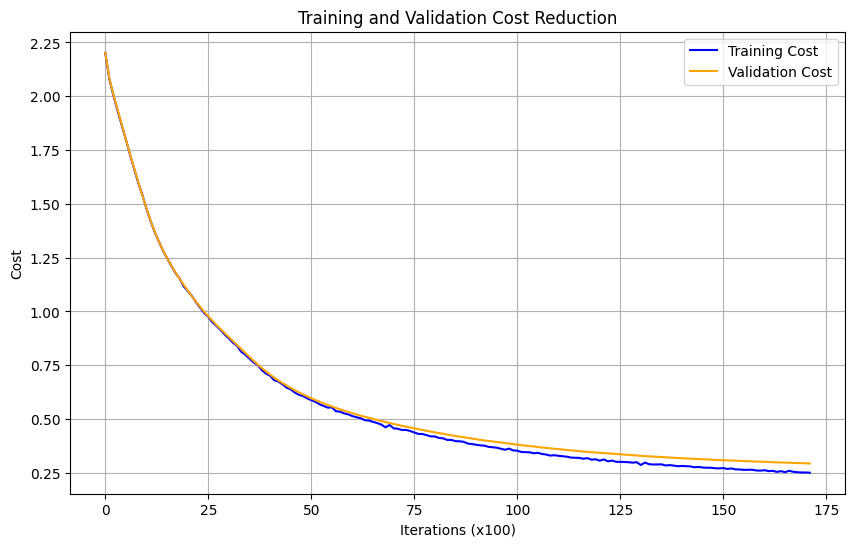

Accuracy on Test Data: 92.41%


In [3]:
# Parameters for training
layers_dims = [784, 20, 7, 5, 10]  # 784 input, 3 hidden layers: 20, 7, 5 neurons, output of 10 classes
learning_rate = 0.009
num_iterations = 100000  # Hoping for early stopping
log_interval = 100
batch_size = 512
stopping_steps = 100
validation_split = 0.2
use_batchnorm = False
lambd = 0.0  # No regularization
verbose = True  # Log progress

# Load MNIST dataset
X_train, Y_train, X_test, Y_test = load_mnist()

# Initialize the model
model = DeepNeuralNetwork(
    layers_dims,
    num_iterations=num_iterations,
    log_interval=log_interval,
    learning_rate=learning_rate,
    batch_size=batch_size,
    use_batchnorm=use_batchnorm,
    lambd=lambd,
    validation_split=validation_split,
    early_stopping=True,
    stopping_steps=stopping_steps,
    verbose=verbose
)

# Start timing
start_time = time.time()

# Train the model
costs, best_parameters,  train_accuracy, val_accuracy = model.train(X_train, Y_train)

# Compute training time in minutes
end_time = time.time()
elapsed_time = (end_time - start_time) / 60
print(f"Training completed in {elapsed_time:.2f} minutes.")

# Unpack training and validation costs from the list of tuples
train_costs, val_costs = zip(*costs)

# Plot training and validation costs
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_costs)), train_costs, label="Training Cost", color="blue")
plt.plot(range(len(val_costs)), val_costs, label="Validation Cost", color="orange")
plt.xlabel("Iterations (x100)")
plt.ylabel("Cost")
plt.title("Training and Validation Cost Reduction")
plt.legend()
plt.grid()
plt.show()

# Evaluate the model on the test set
accuracy = model.predict(X_test, Y_test)
print(f"Accuracy on Test Data: {accuracy:.2f}%")

# Conducting Multiple Experiments

In [12]:
# Define the experiment configurations
experiment_configs = [
    {"stopping_steps": 100, "use_batchnorm": False, "lambd": 0.0},
    {"stopping_steps": 100, "use_batchnorm": True, "lambd": 0.0},
    {"stopping_steps": 100, "use_batchnorm": False, "lambd": 0.1},
    {"stopping_steps": 100, "use_batchnorm": True, "lambd": 0.1},
    {"stopping_steps": 300, "use_batchnorm": False, "lambd": 0.0},
    {"stopping_steps": 300, "use_batchnorm": True, "lambd": 0.0},
    {"stopping_steps": 300, "use_batchnorm": False, "lambd": 0.1},
    {"stopping_steps": 300, "use_batchnorm": True, "lambd": 0.1},
]

# Load the MNIST dataset
X_train, Y_train, X_test, Y_test = load_mnist()

# Base parameters for all experiments
base_params = {
    "layers_dims": [784, 20, 7, 5, 10],
    "num_iterations": 100000,
    "learning_rate": 0.009,
    "batch_size": 512,
    "validation_split": 0.2,
    "early_stopping": True,
    "verbose": False,  # Disable verbose logging for batch experiments
}

# Run experiments and collect results
results = []
for config in experiment_configs:
    # Initialize the model
    model = DeepNeuralNetwork(
        **base_params,
        use_batchnorm=config["use_batchnorm"],
        lambd=config["lambd"],
        stopping_steps=config["stopping_steps"]
    )

    # Start timing the experiment
    start_time = time.time()

    # Train the model
    costs, best_parameters, train_accuracy, val_accuracy = model.train(X_train, Y_train)

    # Measure the elapsed time
    elapsed_time = (time.time() - start_time) / 60

    # Evaluate on the test set
    test_accuracy = model.predict(X_test, Y_test)

    # Collect the results
    results.append({
        "Stopping Steps": config["stopping_steps"],
        "L2 Regularization": config["lambd"],
        "Batch Normalization": config["use_batchnorm"],
        "Train Accuracy": train_accuracy,
        "Validation Accuracy": val_accuracy,
        "Test Accuracy": test_accuracy,
        "Training Time (min)": round(elapsed_time, 2)
    })

# Create a DataFrame from the results
df_results = pd.DataFrame(results)

# Display the DataFrame
display(df_results)

Training set: 60000 samples
Test set: 10000 samples


,Stopping Steps,L2 Regularization,Batch Normalization,Train Accuracy,Validation Accuracy,Test Accuracy,Training Time (min)
0,100,0.0,False,93.497914,92.649996,92.409998,0.75
1,100,0.0,True,91.627085,91.149998,91.439998,0.79
2,100,0.1,False,93.504167,92.691666,92.389995,0.73
3,100,0.1,True,89.300001,88.933331,88.999999,0.52
4,300,0.0,False,94.918752,93.316668,93.390000,1.17
5,300,0.0,True,94.162500,92.641664,92.839998,1.50
6,300,0.1,False,95.233333,93.650001,93.409997,1.34
7,300,0.1,True,89.943749,89.708334,89.589995,0.58
